# Reservoir computing clásico y cuántico en señal simple.

## Carga de librerías.

In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from scipy.signal import hilbert, butter, filtfilt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import random

## Generación de la señal random.

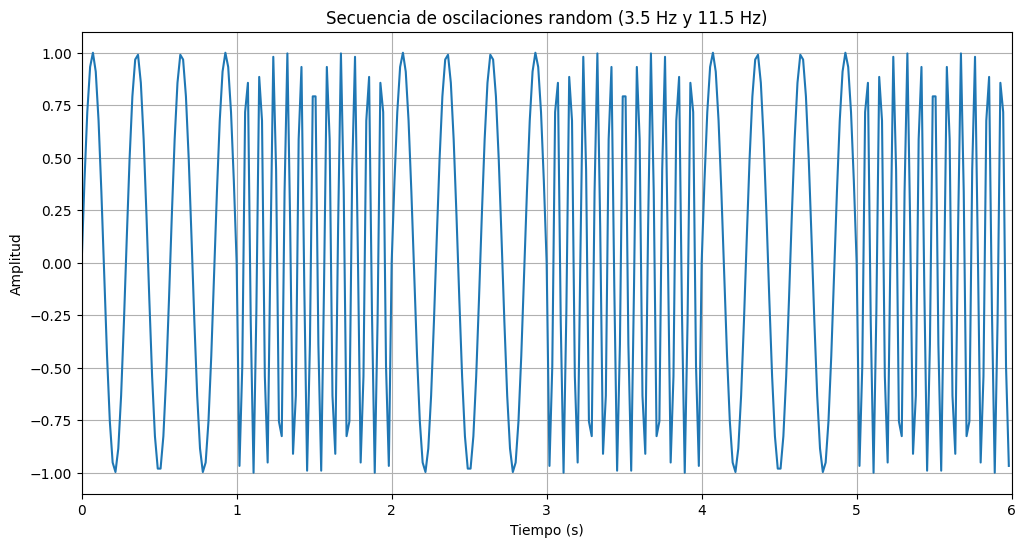

In [2]:
# Parámetros  
fs = 55            # Frecuencia de muestreo en Hz  
t_total = 6        # Duración total en segundos  
f1 = 3.5            # Frecuencia de la primera oscilación en Hz  
f2 = 11.5           # Frecuencia de la segunda oscilación en Hz  
duracion_segmento = 1  # Duración de cada segmento en segundos  
num_repeticiones = 6 # Número total de segmentos (3 de cada oscilacion) 

# vector de tiempo
t = np.arange(0, t_total, 1/fs) 

# Generamos las oscilaciones aleatorias   

amplitud = 1  # Amplitud aleatoria para la osc. 

# Inicializamos la secuencia  
secuencia = np.zeros_like(t)

# Llenar la secuencia con oscilaciones alternando  
for i in range(num_repeticiones):  
    if i % 2 == 0:  # Índices pares para la primera oscilación  
        start = i * duracion_segmento * fs  
        end = start + duracion_segmento * fs  
        secuencia[start:end] = amplitud  * np.sin(2 * np.pi * f1 * t[start:end])  
    else:  # Índices impares para la segunda oscilación  
        start = i * duracion_segmento * fs  
        end = start + duracion_segmento * fs  
        secuencia[start:end] = amplitud * np.sin(2 * np.pi * f2 * t[start:end])
# Graficar la señal  
plt.figure(figsize=(12, 6))  
plt.plot(t, secuencia)  
plt.title('Secuencia de oscilaciones random (3.5 Hz y 11.5 Hz)')  
plt.xlabel('Tiempo (s)')  
plt.ylabel('Amplitud')  
plt.xlim(0, t_total)  
plt.grid()  
plt.show()

## Implementación clásica.

In [3]:
# Parámetros
num_input_channels = 1      # Dimensionalidad de entrada (1 canal)
num_reservoir_neurons = 10   # Número de neuronas en el reservorio
num_readout_neurons = 1      # Número de neuronas de salida

num_training_samples = t.shape[0] # Número de muestras de entrenamiento

# Generar pesos de entrada al reservorio
input2res = np.random.randn(num_reservoir_neurons, num_input_channels)

# Generar pesos recurrentes del reservorio
res2res = np.random.randn(num_reservoir_neurons, num_reservoir_neurons)


# Generar pesos recurrentes del reservorio
res2res = np.random.randn(num_reservoir_neurons, num_reservoir_neurons)

# Normalizar las columnas de los pesos recurrentes
res2res = res2res / np.linalg.norm(res2res, axis=0)

# Sesgo del reservorio
input_bias = np.random.rand(num_reservoir_neurons, 1)

sec = secuencia.reshape(1, len(secuencia))


# Estados iniciales del reservorio
#reservoir_states = np.zeros((num_reservoir_neurons, num_training_samples + 1))
reservoir_states = np.random.randn(num_reservoir_neurons,num_training_samples + 1);

# Dinámicas del reservorio
for i in range(num_training_samples):
    reservoir_states[:, i + 1] = np.tanh(
        #(0.05 * input2res @ secuencia[i, np.newaxis]) +
        (0.05 * input2res @ sec[:, i]) +
        (0.95 * res2res @ reservoir_states[:, i]) +
        input_bias.flatten()
    )

# Extracción de la envolvente superior usando Hilbert transform
RS = reservoir_states - np.mean(reservoir_states,axis=1, keepdims=True)
print(RS.shape)
analytic_signal = hilbert(RS)
amplitude_envelope = np.abs(analytic_signal)

print(analytic_signal.shape)
print(RS.shape)
print(amplitude_envelope.shape)

(10, 331)
(10, 331)
(10, 331)
(10, 331)


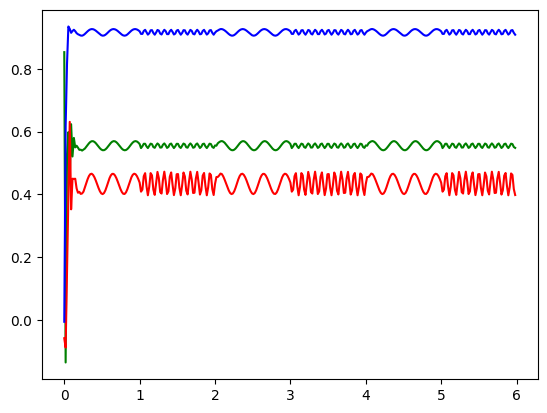

In [4]:
# estados puros del reservoir.
plt.plot(t, reservoir_states[0, 1:], color = 'green')
plt.plot(t, reservoir_states[1, 1:], color = 'red')
plt.plot(t, reservoir_states[2, 1:], color = 'blue')
plt.show()

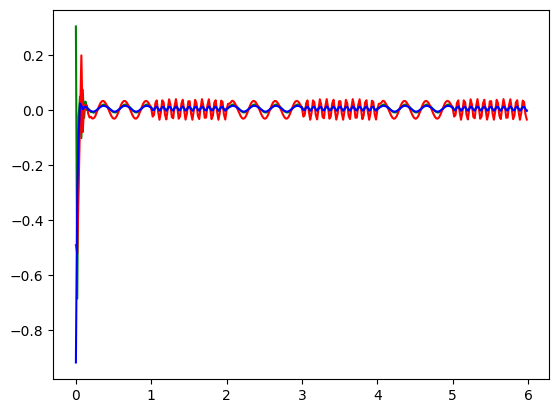

In [5]:
# estados centrados en el 0.
plt.plot(t, RS[0, 1:], color = 'green')
plt.plot(t, RS[1, 1:], color = 'red')
plt.plot(t, RS[2, 1:], color = 'blue')
plt.show()

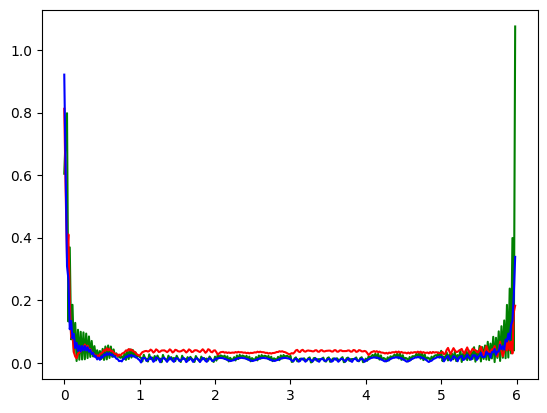

In [6]:
# envolvente de los estados.
plt.plot(t, amplitude_envelope[0, 1:], color = 'green')
plt.plot(t, amplitude_envelope[1, 1:], color = 'red')
plt.plot(t, amplitude_envelope[2, 1:], color = 'blue')
plt.show()

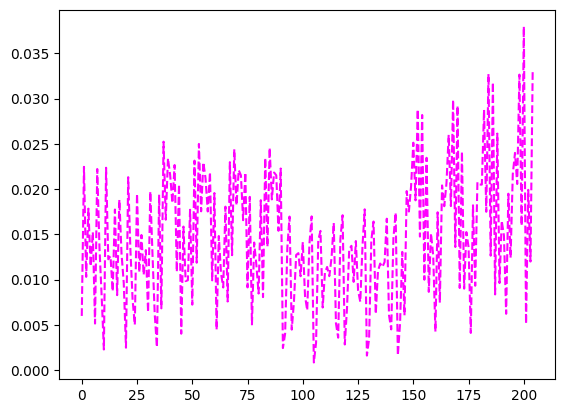

In [7]:
# Eliminamos los primeros 75 puntos para estabilizar el reservorio
stable_start = min(75, amplitude_envelope.shape[1])
input_sequence = amplitude_envelope[:, stable_start:-50]
plt.plot(input_sequence[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

In [8]:
# Agrupamiento (clustering)
num_clusters = 2  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence.T)

# Resultados
idx = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx.shape)

Centroides de los clústeres:
[[0.01110634 0.03707934 0.00903466 0.01453899 0.02924347 0.00832074
  0.025094   0.05774146 0.02146124 0.05612318]
 [0.01781673 0.03245812 0.01219423 0.04212361 0.04837016 0.01060445
  0.04713519 0.08642835 0.01260662 0.06924663]]
(206,)


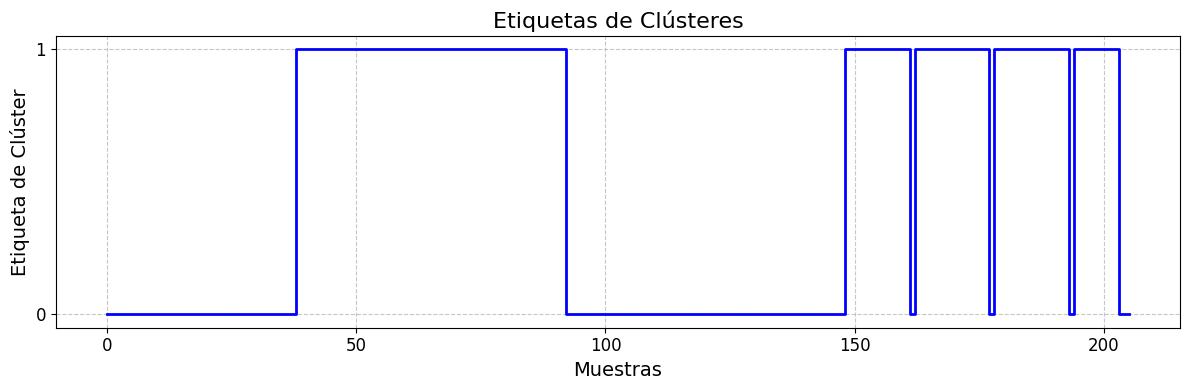

In [9]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence.shape[1]), idx, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xlim(100, 200)  
plt.tight_layout() 
plt.show()

## Implementación cuántica.

In [10]:
# Número de qubits (tamaño del reservoir cuántico)
num_qubits = 10
# Profundidad del circuito del reservoir
num_layers = 1  

# Creamos un dispositivo cuántico
dev = qml.device("default.qubit", wires=num_qubits)

In [11]:
# Definimos el Quantum Reservoir  
def quantum_reservoir(reservoir_weights):  
    """Quantum Reservoir con compuertas CNOT y rotaciones."""    
    for i in range(num_qubits):
         for j in range(num_qubits):
            # Rotación aleatoria en cada qubit  
            qml.RX(reservoir_weights[i,j], wires= i)
            # Entrelazamiento con el siguiente qubit (circular)  
            control_qubit = i 
            target_qubit = (i + 1) % num_qubits  
            qml.CNOT(wires=[control_qubit, target_qubit])

In [12]:
# Definicón del nodo cuántico
@qml.qnode(dev)
def quantum_echo_state_network(input_data, prev_output, weights_in, weights_rc, reservoir_weights):
    """Quantum Echo State Network (QESN)"""
    # Encode input and previous output into qubits
    for i in range(num_qubits):
        qml.RX(.05*weights_in[i] * input_data + .95*weights_rc[i] * prev_output[i], wires=i)
    
    # Evolve through the quantum reservoir
    quantum_reservoir(reservoir_weights)
    
    # Measure expectation values (output features)
    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

In [13]:
# Initialize parameters
weights_in = np.random.uniform(-np.pi, np.pi, num_qubits)
weights_rc = np.random.uniform(-np.pi, np.pi, num_qubits)
reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))

sec = secuencia.reshape(1, len(secuencia))
input_series = sec
time_steps = input_series.shape[1]

# Run QESN
outputs = np.zeros((num_qubits, time_steps))
prev_output = np.zeros(num_qubits)  # Initial output

for t0 in range(time_steps):
    q_output = quantum_echo_state_network(input_series[:, t0], prev_output, weights_in, weights_rc, reservoir_weights)
    final_output = np.tanh(q_output)  # Apply tanh non-linearity

    # Almacenar el resultado en la lista
    outputs[:, t0] = np.array(final_output).squeeze()
    #outputs.append(final_output)
    prev_output = final_output  # Recurrent connection
    print(f"Step {t0}: {outputs[:, t0]}")

Step 0: [ 0.35908794 -0.31106196 -0.62618574  0.34021298  0.06861864  0.00668932
 -0.08964678  0.18675437 -0.25915185  0.23543041]
Step 1: [ 0.25463317 -0.11717888  0.34774311  0.55414     0.06711393  0.00641663
 -0.08842716  0.10535451 -0.24141261  0.2076577 ]
Step 2: [ 0.31191763 -0.2359765  -0.48399529  0.50550755  0.06800812  0.00623572
 -0.08755694  0.15321673 -0.24373334  0.21476456]
Step 3: [ 2.93418642e-01 -1.48063529e-01 -3.66862741e-04  5.24697799e-01
  6.84807394e-02  6.11500878e-03 -8.68684322e-02  1.35095645e-01
 -2.43497364e-01  2.14791230e-01]
Step 4: [ 0.30297063 -0.20606986 -0.64112788  0.51497416  0.06861709  0.00607719
 -0.08663943  0.14557652 -0.24354177  0.21517652]
Step 5: [ 0.29677652 -0.1706616   0.32833747  0.52100861  0.06840985  0.00612931
 -0.08696169  0.13829017 -0.24351589  0.21459193]
Step 6: [ 0.29365508 -0.20463104 -0.50945619  0.52224256  0.06786172  0.00626162
 -0.08770202  0.13619021 -0.24346601  0.21332083]
Step 7: [ 0.28626067 -0.19640316  0.121841

(10, 330)


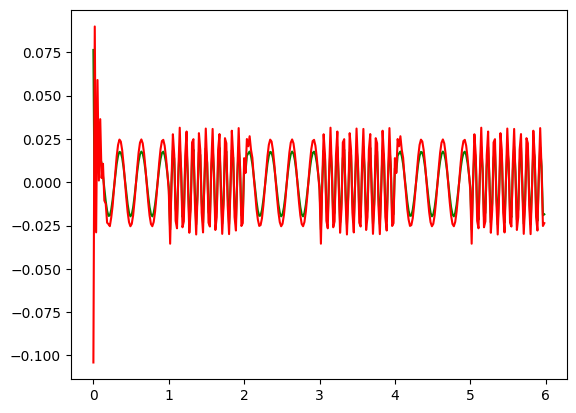

In [14]:
# Extracción de la envolvente superior usando Hilbert transform
RS_cuantico = outputs - np.mean(outputs,axis=1, keepdims=True)
print(RS_cuantico.shape)

plt.plot(t, RS_cuantico[0, :], color = 'green')
plt.plot(t, RS_cuantico[1, :], color = 'red')
plt.show()

In [15]:
# Función para aplicar un filtro pasa-banda
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Parámetros
fs = 55  # Frecuencia de muestreo
lowcut = 1  # Frecuencia baja del filtro
highcut = 12  # Frecuencia alta del filtro

# Aplicamos filtro antes de Hilbert
x_filtered = bandpass_filter(RS_cuantico, lowcut, highcut, fs)

In [16]:
analytic_signal = hilbert(x_filtered)
amplitude_envelope = np.abs(analytic_signal)
print(analytic_signal.shape)
print(amplitude_envelope.shape)

(10, 330)
(10, 330)


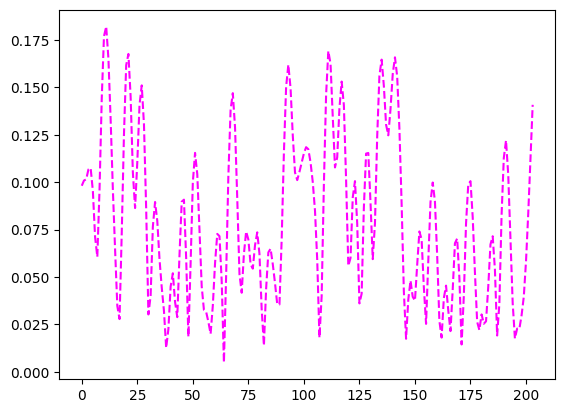

In [17]:
# Eliminamos los primeros puntos para estabilizar el reservorio.
stable_start = min(75, amplitude_envelope.shape[1])
input_sequence = amplitude_envelope[:, stable_start:-50]
plt.plot(input_sequence[2, 1:], linestyle="dashed", color = 'magenta')
plt.show()

In [18]:
# Agrupamiento (clustering)
num_clusters = 2  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence.T)

# Resultados
idx = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx.shape)

Centroides de los clústeres:
[[0.0151715  0.02079999 0.12133985 0.00862742 0.00206728 0.00038273
  0.00109008 0.01352175 0.00021542 0.00412341]
 [0.01782439 0.02386103 0.04763734 0.0103399  0.00262247 0.00049266
  0.00145402 0.01582978 0.00025955 0.00506439]]
(205,)


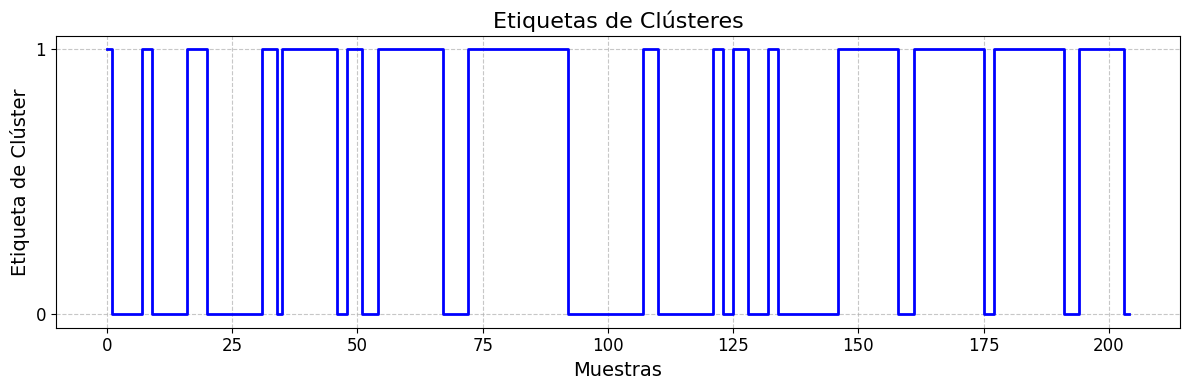

In [19]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence.shape[1]), idx, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xlim(100, 200)  
plt.tight_layout() 
plt.show()

## Implementación cuántica con estado.

In [20]:
# Número de qubits (tamaño del reservoir cuántico)
num_qubits = 3
# Profundidad del circuito
num_layers = 1  

# Creamos un dispositivo cuántico.
dev = qml.device("default.qubit", wires=num_qubits)

In [21]:
# Definimos el Quantum Reservoir  
def quantum_reservoir(reservoir_weights):  
    """Quantum Reservoir con compuertas CNOT y rotaciones."""    
    for i in range(num_qubits):
         for j in range(num_qubits):
            # Rotación aleatoria en cada qubit  
            qml.RX(reservoir_weights[i,j], wires= i)
            # Entrelazamiento con el siguiente qubit (circular)  
            control_qubit = i 
            target_qubit = (i + 1) % num_qubits  
            qml.CNOT(wires=[control_qubit, target_qubit])

A diferencia de la otra implementación, devolvemos un vector de probabilidades de los estados del qubit en vez del expectation value.

In [22]:
# Define Quantum Node
@qml.qnode(dev)
def quantum_echo_state_network(input_data, prev_output, weights_in, weights_rc, reservoir_weights):
    """Quantum Echo State Network (QESN)"""
    # Encode input and previous output into qubits
    for i in range(num_qubits):
        qml.RX(.05*weights_in[i] * input_data + .95*weights_rc[i] * prev_output[i], wires=i)
    
    # Evolve through the quantum reservoir
    quantum_reservoir(reservoir_weights)
    
    # Devolvemos un vector de probabilidades de los estados.
    return qml.probs(wires=range(num_qubits))

In [23]:
# Initialize parameters
weights_in = np.random.uniform(-np.pi, np.pi, num_qubits)
weights_rc = np.random.uniform(-np.pi, np.pi, num_qubits)
reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))

sec = secuencia.reshape(1, len(secuencia))
input_series = sec
time_steps = input_series.shape[1]

# Run QESN
outputs = []
prev_output = np.zeros(num_qubits)  # Initial output

for t0 in range(time_steps):
    q_prob = quantum_echo_state_network(input_series[0, t0], prev_output, weights_in, weights_rc, reservoir_weights)

    final_output = np.tanh(q_prob) # usamos la tanh de los estados cuánticos(en probabilidades)

    # Almacenamos el resultado en la lista.
    outputs.append(final_output)
    prev_output = final_output  # Recurrent connection
    print(f"Step {t0}: {final_output}")

# Convertimos outputs a numpy array.
outputs = np.array(outputs)

Step 0: [0.27590587 0.10438913 0.13312153 0.04214064 0.15848084 0.01181416
 0.00180616 0.25658865]
Step 1: [0.31219095 0.1289938  0.11786859 0.02769147 0.1352995  0.01463164
 0.00147877 0.24393052]
Step 2: [0.32687376 0.12889737 0.11950352 0.02518838 0.13701857 0.01343414
 0.00156488 0.22877921]
Step 3: [0.33119873 0.13077871 0.11867792 0.02420672 0.13573937 0.01458774
 0.00186332 0.22394743]
Step 4: [0.33308129 0.13115397 0.11857933 0.02388022 0.13558108 0.01477927
 0.00196048 0.22185809]
Step 5: [0.33157657 0.13025985 0.11908947 0.02398907 0.13618022 0.01433107
 0.00180956 0.22372425]
Step 6: [0.32681021 0.12822447 0.12006074 0.02456166 0.13738821 0.01344472
 0.00149244 0.22925513]
Step 7: [0.31918692 0.12532495 0.12121171 0.02557436 0.13888725 0.01257821
 0.00117787 0.23769822]
Step 8: [0.30960316 0.12197239 0.12226515 0.02694097 0.14033122 0.01214617
 0.00101901 0.24778751]
Step 9: [0.29949561 0.11867237 0.12305758 0.02847621 0.14146978 0.01228782
 0.00106802 0.25789348]
Step 10: [

In [24]:
outputs = outputs.T
outputs.shape

(8, 330)

(8, 330)


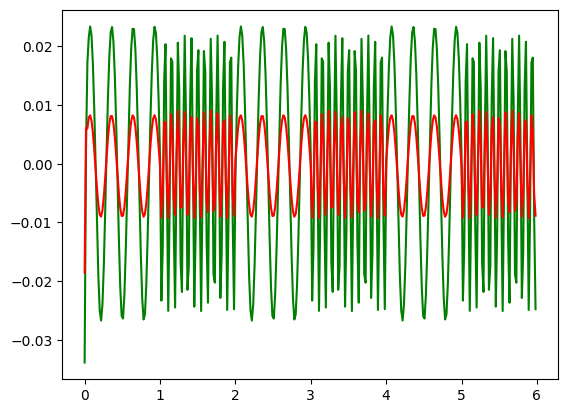

In [25]:
RS_cuantico2 = outputs - np.mean(outputs,axis=1, keepdims=True)
print(RS_cuantico2.shape)

plt.plot(t, RS_cuantico2[0, :], color = 'green')
plt.plot(t, RS_cuantico2[1, :], color = 'red')
plt.show()

In [26]:
# Parámetros
fs = 55  # Frecuencia de muestreo
lowcut = 3.5  # Frecuencia baja del filtro
highcut = 11.5  # Frecuencia alta del filtro

# Aplicar filtro pasa banda antes de Hilbert
x_filtered2 = bandpass_filter(RS_cuantico2, lowcut, highcut, fs)

In [27]:
analytic_signal = hilbert(x_filtered2)
amplitude_envelope_cuant2 = np.abs(analytic_signal)
print(analytic_signal.shape)
print(amplitude_envelope_cuant2.shape)

(8, 330)
(8, 330)


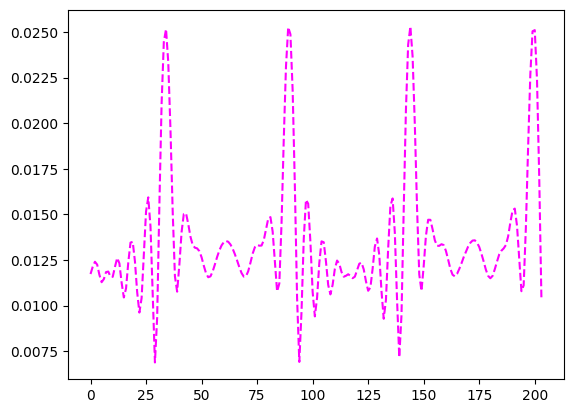

In [28]:
# Eliminamos primeros puntos del reservoir.
stable_start = min(75, amplitude_envelope_cuant2.shape[1])
input_sequence_cuant2 = amplitude_envelope_cuant2[:,stable_start:-50]
plt.plot(input_sequence_cuant2[0,1:], linestyle="dashed", color = 'magenta')
plt.show()

In [29]:
# Agrupamiento (clustering)
num_clusters = 2  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence_cuant2.T)

# Resultados
idx = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx.shape)

Centroides de los clústeres:
[[0.01252588 0.00456148 0.00150387 0.00177645 0.00194278 0.00073422
  0.00025685 0.01293547]
 [0.02278246 0.00831403 0.0028326  0.0032065  0.00365718 0.00109663
  0.00038366 0.02386256]]
(205,)


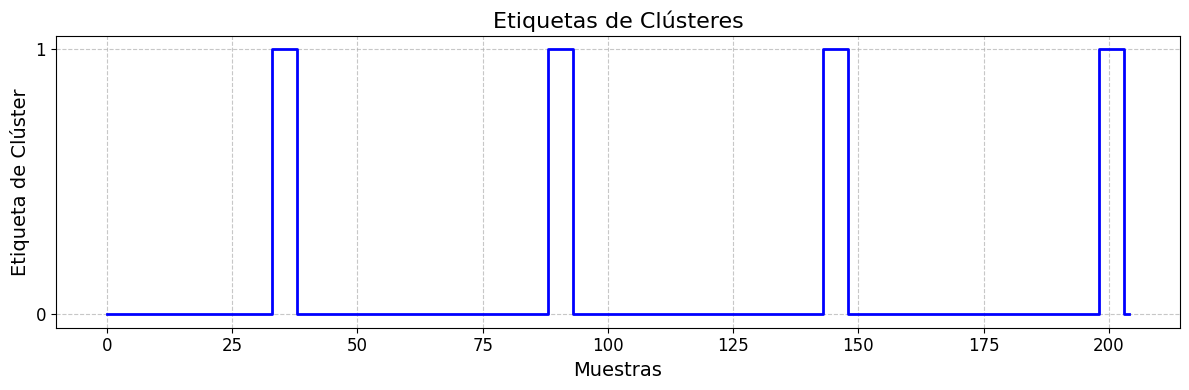

In [30]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence_cuant2.shape[1]), idx, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xlim(100, 200)  
plt.tight_layout() 
plt.show()